# Домашнее задание №1. Softmax Regression.

Нужно реализовать много-классовую логистическую регрессию с помощью softmax c поддержкой L1/L2 регуляризации. После этого сравнить с sklearn реализацией [SGDClassifier(loss="log_loss")](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
.

## Задание №1 (10 баллов)

Реализовать класс SoftMaxRegression и его методы - init, fit, predict c возможностью конфигурации
регуляризации. 
Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**. 

Остальные функции реализовать на ваше усмотрение. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
class SoftMaxRegression:
    def __init__(self,  penalty = None, lambd=0.01, learning_rate = 0.001, max_iter=10000):
        self.penalty= penalty
        self.lambd = lambd # параметр регуляризации
        self.learning_rate = learning_rate # шаг обучения
        self.max_iter = max_iter # количество итераций

    def accuracy(self, y_pred, y_real):
        type_pred = np.argmax(y_pred, axis=1)
        type_real = np.argmax(y_real, axis=1)
        return np.mean(type_pred == type_real)

    def softmax(self, x, w):
        pred = -np.dot(x, w)
        help_calc = np.sum(np.exp(pred), axis=1)
        p = np.divide(np.exp(pred), np.tile(help_calc, (pred.shape[1], 1)).T)
        return p

    #cчитаем лосс
    def objective_value(self, x,  w,  y):
        predict = -np.dot(x, w)
        A = np.dot(np.dot(x, w), y.T)
        loss = (np.trace(A) + np.sum(np.log(np.sum(np.exp(predict), axis=1)))) / len(x)
        if self.penalty == "l1":
            loss += self.lambd * np.sum(np.abs(w))
        elif self.penalty == "l2":
            loss += self.lambd * np.sum(np.square(w))
        return loss

    #градинет лосса
    def objective_grad(self, x, w, y):
        p = self.softmax(x,w)
        grad = np.dot(x.T, (y - p))  / len(x)
        if self.penalty == "l1":
            grad += self.lambd * np.sign(w)
        elif self.penalty == "l2":
            grad += 2 * self.lambd * w
        return grad

    # подсчет весов, всех лосов, метрики
    def fit(self, X_train, Y_train, X_test, Y_test):        
        train_loss_list = []
        test_loss_list = []
        accuracy_val = []
        current_weight = np.random.uniform(-0.5, 0.5, size=(X_train.shape[1], Y_train.shape[1])) # начальные веса
        
        for step in range(self.max_iter):
            #cчитаем веса
            grad = self.objective_grad(X_train, current_weight, Y_train)
            current_weight -= self.learning_rate * grad
            
            # считаем лоссы
            train_loss = self.objective_value(X_train, current_weight, Y_train)
            test_loss = self.objective_value(X_test, current_weight, Y_test)
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            
            # cчитаем метрику
            accuracy_val.append(self.accuracy(self.predict(X_test, current_weight), Y_test))
            
        return {"train_loss_list": train_loss_list, "test_loss_list": test_loss_list, "accuracy": accuracy_val}
             
    # предсказание
    def predict(self, x, w):
        pred = -np.dot(x, w)
        help_calc = np.sum(np.exp(pred), axis=1)
        y_predict = np.divide(np.exp(pred), np.tile(help_calc, (pred.shape[1], 1)).T) 
        return y_predict
        

## Задание №2 (10 баллов)

Загрузите любой датасет много-классовой классификации, сделайте предобработку, разбейте на тренировочную и тестовую выборку  и оцените работу вашего алгоритма. Предпочтительно использовать метрику точности(accuracy) для оценки алгоритма. 

В рамках оценки, воспользуйтесь sklearn реализацией много-классовой логистической регрессии. **Проверьте что ваши метрики не хуже sklearn версии (разница 1-2% допустима) на моделях без регуляризации, с L1 и с L2 регуляризации.**

#### Работа с датасетом (1 балл)

Загрузите выбранный датасет много-классовой классификации, обработайте его, сделайте разбиение на тренировочную и тестовую выборку. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table).

In [4]:
# C помощью химического анализа определить тип вина
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 

# metadata 
# print(X.info()) 

Проверим корелляцию признаков


<Axes: >

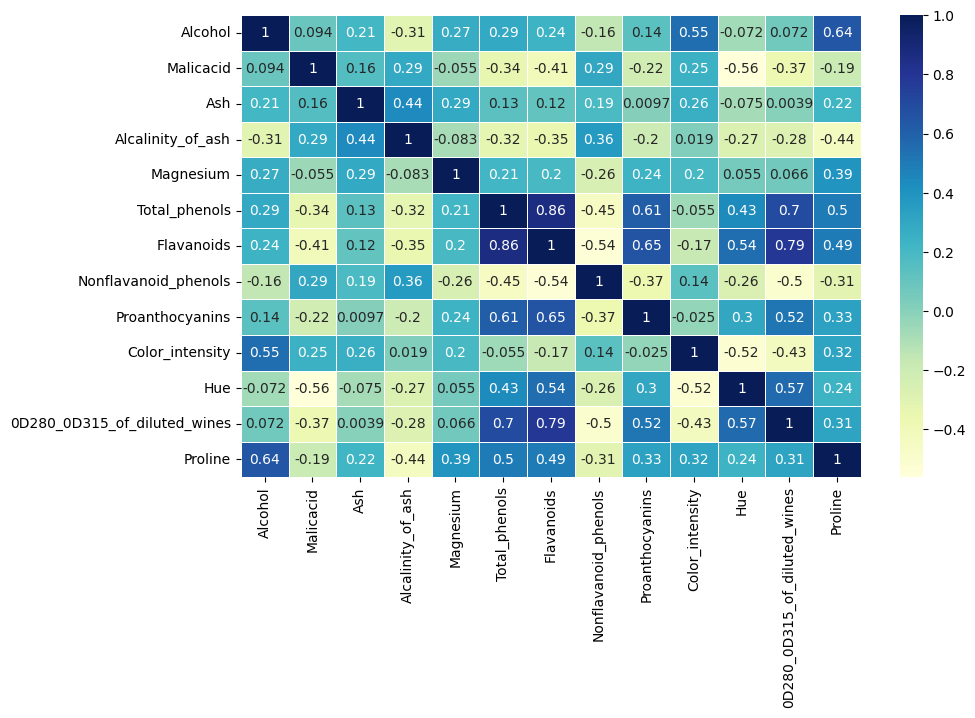

In [5]:
corrmat = X.corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.heatmap(corrmat, cmap="YlGnBu", linewidths=.5, annot=True)

Кажется, что присутствует корреляция признака Flavanoid и Total_phenols, но навреное, имеет смысл не убирать этот признак, чтобы посмотреть, как регуляризация будет с этим справлятся.


Также выполним нормализацию признаков и разделим на train и test выборки.

In [6]:
# разделение данных на тренировочную и тестовою выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# one hot encoding
enc = OneHotEncoder(sparse_output=False)
y_one_hot_train = enc.fit_transform(y_train)
y_one_hot_test = enc.fit_transform(y_test)

#### Обучение модели и сравнение с sklearn имплементацией

Обучите 3 модели - обычную, с L1 реализацией, с L2 реализацией и сравните с аналогичной sklearn имплементацией много-классовой логистической регрессии. 

В рамках обучения модели требуется визуализировать:

1) График падания значений ошибки на тренировочной выборке в зависимости от итерации.
2) График падания значений ошибки на валидационной выборке в зависимости от итерации.
3) График роста метрики точности в зависимости от итерации.

<span style="color:red">**Модель считается успешно реализованной, если целевая метрика совпадает/лучше sklearn [реализации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)   c log_loss функцией ошибки. 
    
Если разница большая(более 1-2% в пользу sklearn), баллы за ДЗ не проставляются.**</span>

Ваши гиперпараметры должны совпадать с параметрами, которые вы указываете в sklearn версии.

In [7]:
# Отрисовка данных

def plot_graphs(data):
    plt.figure(figsize=(21, 7))

    plt.subplot(1, 2, 1)
    plt.title("Accuracy on test")
    plt.plot(range(len(data["accuracy"])), data["accuracy"], color='r')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("Loss")
    plt.plot(range(len(data["train_loss_list"])), data["train_loss_list"], color='b', label = 'train')
    plt.plot(range(len(data["test_loss_list"])), data["test_loss_list"], color='r', label = 'test')
    plt.legend()
    plt.grid()
    
    plt.show()

#### Обучение обычной модели и сравнение с __SGDClassifier(loss="log_loss", penalty = 'none')__ (3 балла)

/Users/moisha/miniconda3/envs/ml_env/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sklearn accuracy: 94.4
my model accuracy: 94.4


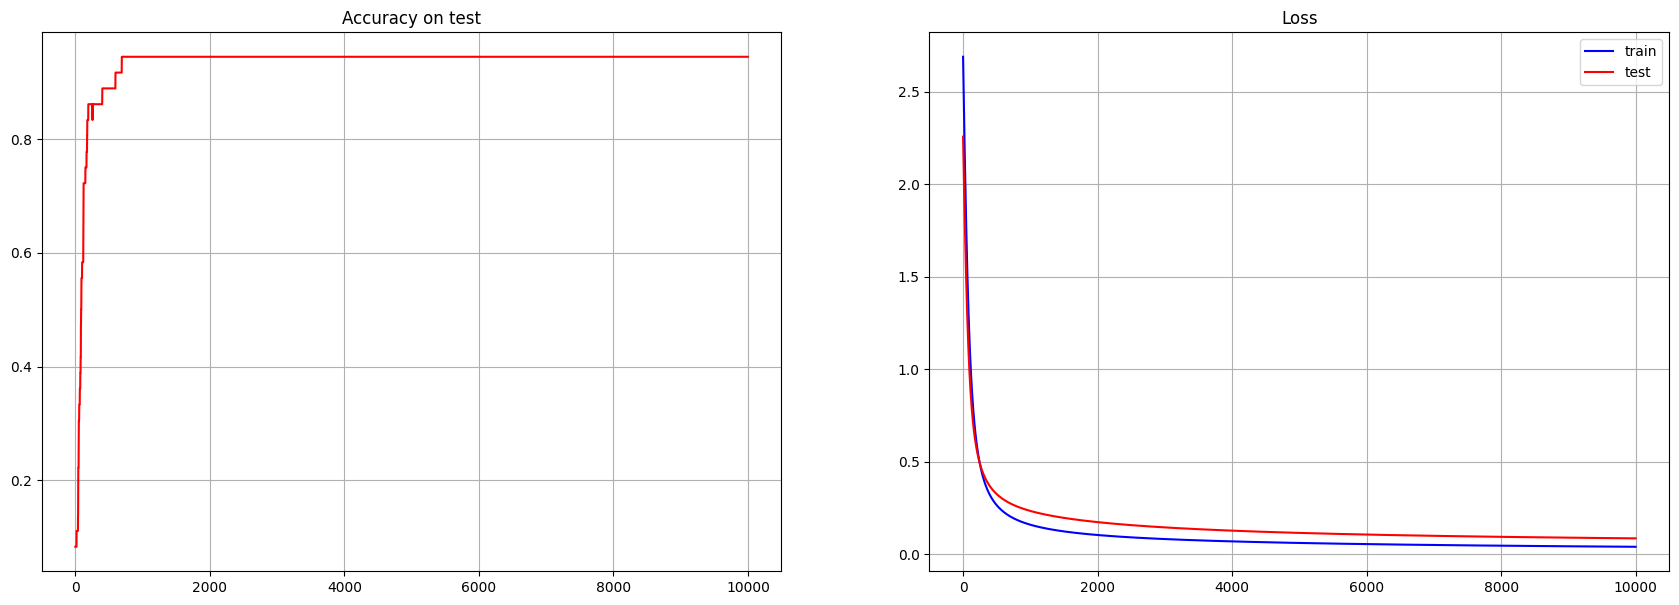

In [8]:
# обработка данных с помощью sklearn
coefs = np.random.uniform(-0, 0, size=(X_train.shape[1], 3)).T
model = SGDClassifier(loss='log_loss', penalty=None, learning_rate='constant', eta0=0.005, max_iter=10000, warm_start=True)
model.fit(X_train, y_train, coef_init=coefs)
model_acc = round(accuracy_score(model.predict(X_test), y_test) * 100, 1) # метрика

# обработка данных с помощью моей SoftMaxRegression
my_model = SoftMaxRegression(penalty=None, learning_rate=0.005, max_iter=10000)
data = my_model.fit(X_train, y_one_hot_train, X_test, y_one_hot_test)
my_model_acc = round(data["accuracy"][-1] * 100, 1) 

# вывод метрики и построение лосов
print(f"sklearn accuracy: {model_acc}")
print(f"my model accuracy: {my_model_acc}")
plot_graphs(data)

#### Обучение модели c L1 регуляризацией и сравнение с __SGDClassifier(loss="log_loss", penalty = 'l1')__ (3 балла)

/Users/moisha/miniconda3/envs/ml_env/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sklearn accuracy: 94.4
my model accuracy: 97.2


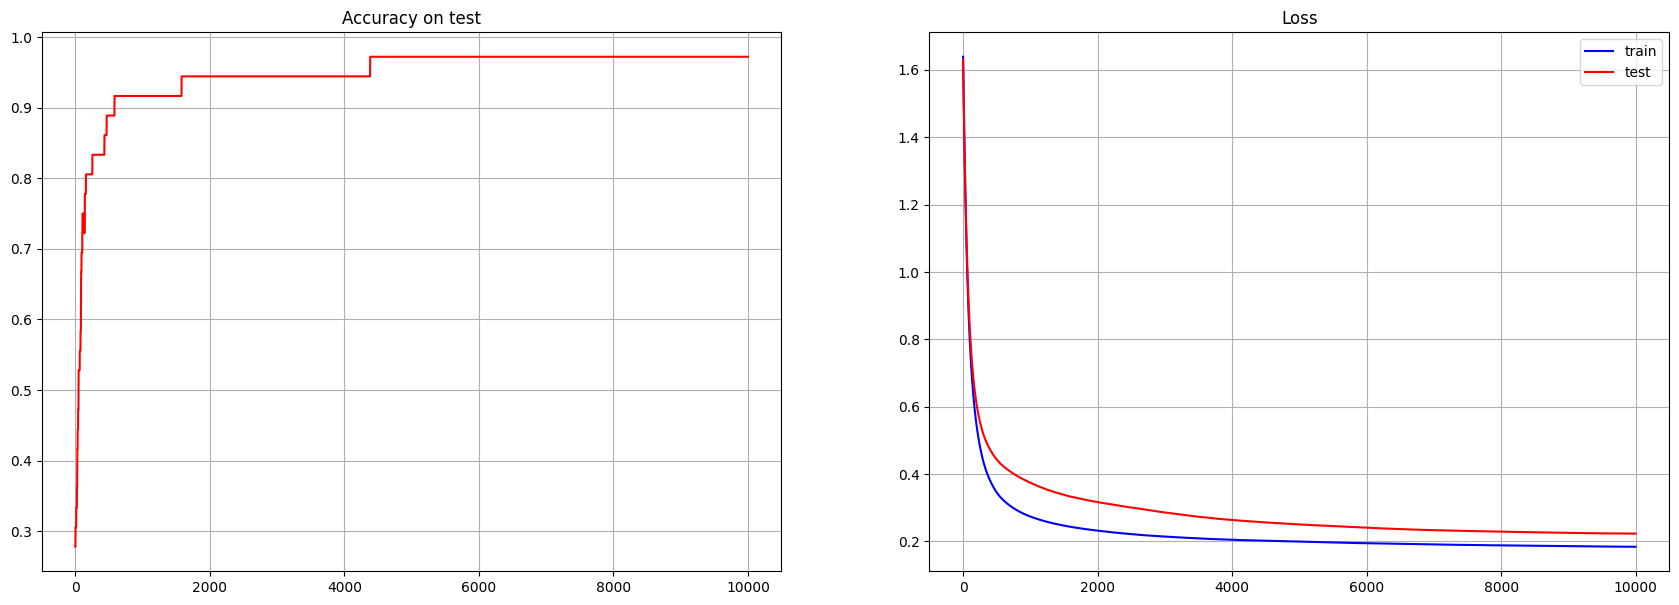

In [9]:
# обработка данных с помощью sklearn
coefs = np.random.uniform(-0, 0, size=(X_train.shape[1], 3)).T
model = SGDClassifier(loss='log_loss', penalty='l1', learning_rate='constant', eta0=0.005, max_iter=10000, warm_start=True)
model.fit(X_train, y_train, coef_init=coefs)
model_acc = round(accuracy_score(model.predict(X_test), y_test) * 100, 1) # метрика

# обработка данных с помощью моей SoftMaxRegression
my_model = SoftMaxRegression(penalty='l1', lambd=0.01, learning_rate=0.005, max_iter=10000)
data = my_model.fit(X_train, y_one_hot_train, X_test, y_one_hot_test)
my_model_acc = round(data["accuracy"][-1] * 100, 1) # метрика

# вывод метрики и построение лосов
print(f"sklearn accuracy: {model_acc}")
print(f"my model accuracy: {my_model_acc}")
plot_graphs(data)

#### Обучение модели c L2 регуляризацией и сравнение с __SGDClassifier(loss="log_loss", penalty = 'l2')__ (3 балла)

/Users/moisha/miniconda3/envs/ml_env/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sklearn accuracy: 94.4
my model accuracy: 94.4


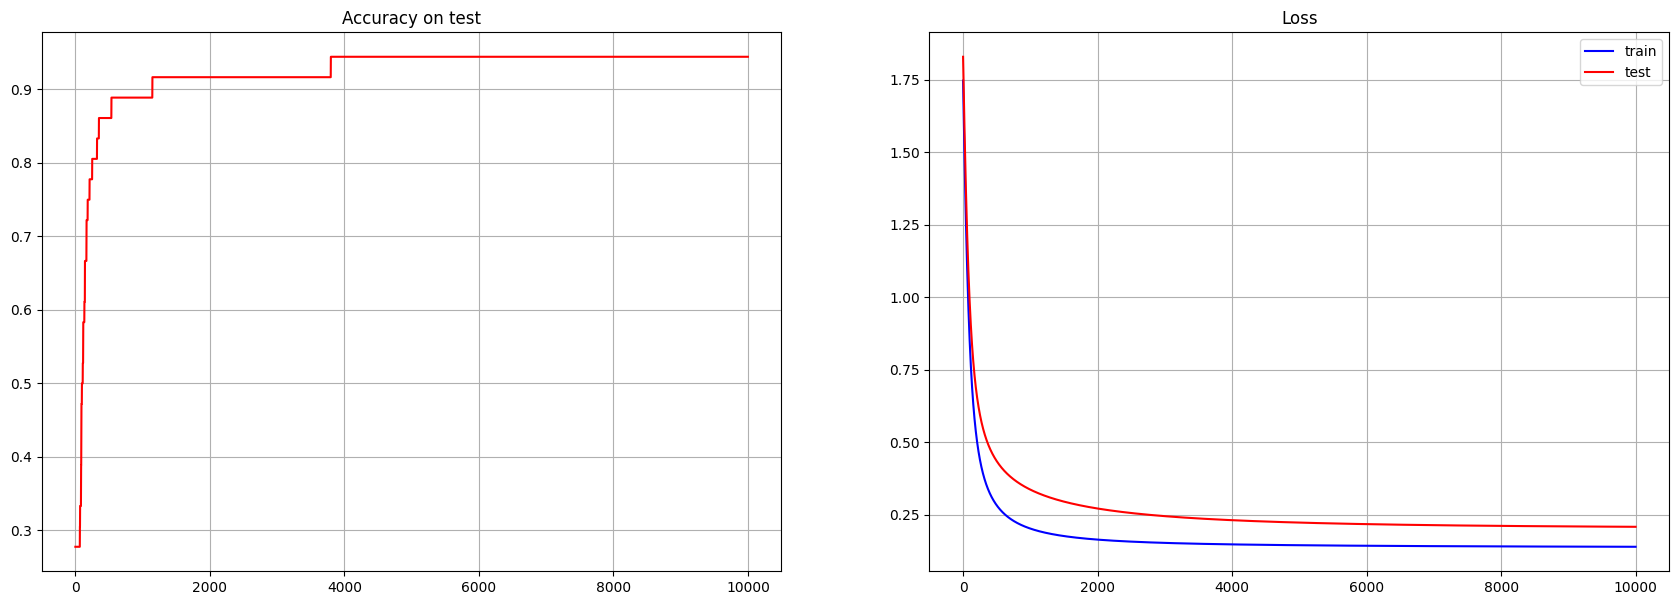

In [10]:
# обработка данных с помощью sklearn
coefs = np.random.uniform(-0, 0, size=(X_train.shape[1], 3)).T
model = SGDClassifier(loss='log_loss', penalty='l2', learning_rate='constant', eta0=0.005, max_iter=10000, warm_start=True)
model.fit(X_train, y_train, coef_init=coefs)
model_acc = round(accuracy_score(model.predict(X_test), y_test) * 100, 1) # метрика

# обработка данных с помощью моей SoftMaxRegression
my_model = SoftMaxRegression(penalty='l2', lambd=0.01, learning_rate=0.005, max_iter=10000)
data = my_model.fit(X_train, y_one_hot_train, X_test, y_one_hot_test)
my_model_acc = round(data["accuracy"][-1] * 100, 1) # метрика

# вывод метрики и построение лосов
print(f"sklearn accuracy: {model_acc}")
print(f"my model accuracy: {my_model_acc}")
plot_graphs(data)